In [ ]:
import cv2
from PIL import Image

# load image from url
sketch = Image.open('workspace/__hakurei_reimu_touhou_drawn_by_ini_inunabe00__f36320cd7eef630772572a8fc987f330.jpg')
sketch

In [ ]:
# 1. 线稿上色
# 注意: 执行这一步时要确保webui->Settings->VAE->SD VAE是Automatic

from utils.webui_screentone_text2img import colorize_sketch

long_side = 1024
seed = 0

prompt = 'masterpiece, best quality, illustration, beautiful and aesthetic, (best illumination, an extremely delicate and beautiful),simple background'
negative_prompt = 'nsfw, nude, lowres, ((bad anatomy)), ((bad hands)), worst quality, low quality, normal quality, jpeg, ((jpeg artifacts))'
url = 'http://127.0.0.1:7860/sdapi/v1/txt2img'


colored = colorize_sketch(sketch, prompt=prompt, negative_prompt=negative_prompt, long_side=long_side, seed=seed, url=url)[0]
colored

In [ ]:
# 2. 上色图转为screentone
# 先手动在webui里将base model换成manga_34000, 将webui->Settings->VAE->SD VAE选为mangatone_default
# 这里实现最好能改成自动的

screentone_rough = colorize_sketch(colored, url=url, prompt='greyscale, monochrome, screentone', negative_prompt='', long_side=long_side, seed=seed)[0]
screentone_rough

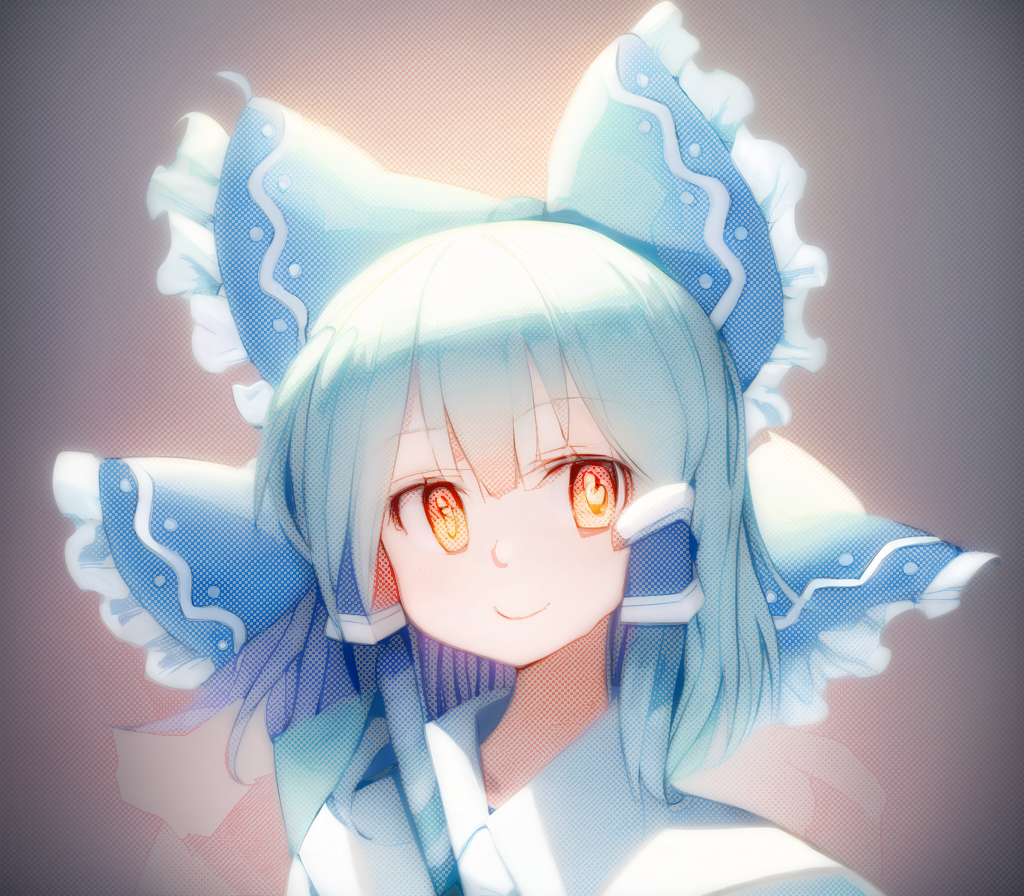

In [36]:
# 3. 后处理
# 下面两张图是最后需要得到的结果

import numpy as np

from utils.blend_screentone import blend_screentone, fgbg_hist_matching

colored = np.array(colored)
screentone_rough = np.array(screentone_rough)

screentone_colorized, layers, layers_vis = blend_screentone(colored, screentone_rough, seed=seed, cluster_n=15)
Image.fromarray(screentone_colorized)

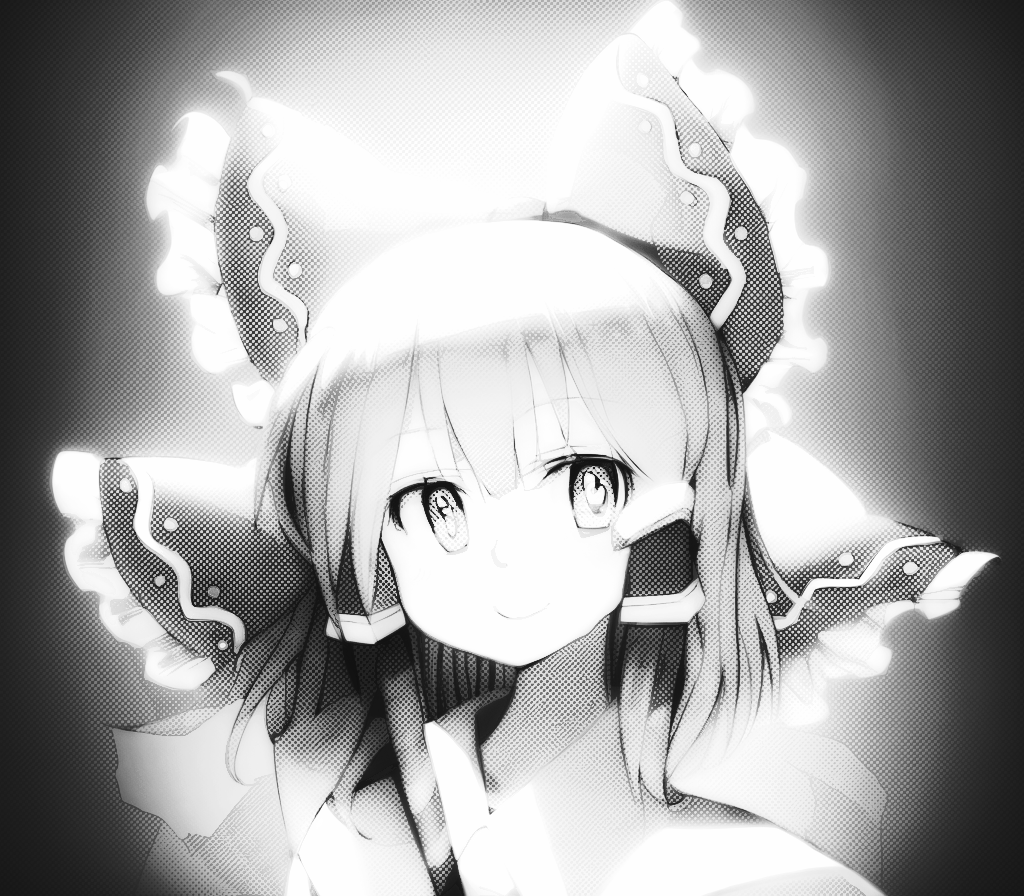

In [37]:
# This example is overexposure, lower the following two values to mitigate it.
screentone_scale = 0.8
color_scale = 0.25

screentone_final = screentone_scale * screentone_rough + color_scale * cv2.cvtColor(colored, cv2.COLOR_RGB2GRAY)[..., None]
screentone_final = np.clip(screentone_final, 0, 255).astype(np.uint8)
sc = cv2.cvtColor(screentone_colorized, cv2.COLOR_RGB2GRAY)
sc_list = [sc[..., None]]
fgbg_hist_matching(sc_list, screentone_final)

final = Image.fromarray(sc_list[0][..., 0])
# final.save('workspace/teaser/final.png')
final